# Fine Tuning Embedding Models for Retrieval on Domain Specific Data
* Notebook by Adam Lang
* Date: 4/7/2025
* This notebook was inspired by Adam Lucek's tutorials.
* This notebook is also inspired by and pulls methodology and code snippets from Philipp Schmid's blog post: [*Fine-tune Embedding models for Retrieval Augmented Generation (RAG)*](https://www.philschmid.de/fine-tune-embedding-model-for-rag).

<img src="https://miro.medium.com/v2/resize:fit:1400/0*AjX-xfa4UvNVu9js.jpg" width=600>

# Background
* Embedding models form the backbone of modern Retrieval Augmented Generation (RAG) pipelines.
* Embeddings provide an LLM with the most similar and relevant context from a vector store or knowledgebase (usually a vector database) to aide it's generation.
* These are commonly used for querying and finding insights among large quantities of unstructured data.

## The Problem
* Too often we default to "off the shelf" standard and generalized embedding models to convert our data into dense vector representations, which are then stored in a vector database and retrieved at runtime.
* While these models are quite powerful to start, they very often give poor results when applied to **domain specific or niche data.**
  * This is usually because embedding models have HIGH DIMENSIONALITY meaning they are trained on diverse datasets. Thus, in lower dimensions where domain specific data lives, retrieval is difficult.
  * Acronyms, abbreviations, and colloquial language are very domain specific and have very different contextual meanings. Think of this as most general purpose embedding models are a "jack of all trades, master of none."
* This is because they very often fail to retrieve the **most relevant or useful documents** related to the actual domain data.
* This error compounds as it is passed to the LLM, which will confidently answer with erroneous data.

## How do we fix this?
* To address this, it's possible to **fine tune** open source embedding models on your own domain specific data to improve retrieved semantic content including the MOST relevant contextual documents.
* This can be done with minimal data prep using [Sentence Transformers](https://sbert.net/).
  * In this notebook we'll walk through how to significantly enhance embedding model performance upwards of 60+% across standard information retrieval metrics for unseen queries through a specific workflow.

## Assumption
* We are training the model to generalize on the existing text chunks in a stored vector database or knowledgebase. We are NOT training on unseen "real world" data.
* The assumption is that we want the embedding model fine tuned to equal the vectors already within our vector store.
* This is so in a RAG pipeline a user query can be more easily embedded and sent to the vector store for retrieval with better results.
* You could use this fine-tuning technique as an offline pre-training method to make sure that before you create your stored text chunks you have domain specific embeddings, but again that may require significant compute power and time based on your use case(s).


## Workflow 
1. Build a synthetic dataset of positive question + chunk pairs
2. Manipulate and prepare the dataset for training and evaluators
3. Evaluate the base performance of the embedding model
4. Fine tunie the embedding model on domain specific data with Matryoshka Representation Learning
5. Publish the fine tuned model to Hugging Face
6. Evaluate the performance of the fine-tuned model



# Install Dependencies

In [1]:
%%capture
!pip install --upgrade sentence-transformers datasets transformers tensorboard

In [6]:
%%capture 
## upgrade torchvision
!pip install --upgrade torchvision 
!pip install --upgrade torch 

Restart kernel after running cell above.

In [1]:
## check torch versions 
import torch 
import torchvision

## print versions 
print(f"PyTorch version: {torch.__version__}")
print(f"Torchvision version: {torchvision.__version__}")

PyTorch version: 2.6.0+cu124
Torchvision version: 0.21.0+cu124


# Check if GPU is available

In [2]:
##check if GPU is available 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 
print(f"Using device: {device}")

# set device for PyTorch operations
if device.type == "cuda":
    torch.cuda.set_device(0) # you can use a different device ID if you have multiple GPUs running


Using device: cuda


In [3]:
import torch

## dependencies for fine tuning embeddings
from sentence_transformers import SentenceTransformer, SentenceTransformerModelCardData, SentenceTransformerTrainingArguments, SentenceTransformerTrainer
from sentence_transformers.evaluation import InformationRetrievalEvaluator, SequentialEvaluator
from sentence_transformers.util import cos_sim
from sentence_transformers.losses import MatryoshkaLoss, MultipleNegativesRankingLoss
from sentence_transformers.training_args import BatchSamplers

## huggingface imports
from datasets import load_dataset, concatenate_datasets

2025-04-07 20:04:45.632856: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-04-07 20:04:45.648630: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-04-07 20:04:45.653535: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-04-07 20:04:45.665064: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Login to Hugging Face
* Used for pushing fine tuned embedding model to the Hugging Face Hub and downloading gated models or datasets

In [4]:
from huggingface_hub import notebook_login

notebook_login()

----
# Dataset Preperation for Fine-Tuning Embeddings

## Assumption
* We assume that we already have text or documents that have been split and chunked and embedded already.
* However, fine-tuning an embedding model is used to enhance the retrieval process on the documents that are stored in a vector database or knowledgebase. This is not necessarily used to fine tune embedddings to create the knowledge base, however it could be adapted for a much larger set of text and documents.

## Details
* Training an embedding model requires a few unique dataset structures.
* A more detailed overview can be found in the [sentence transformers dataset documentation](https://sbert.net/docs/sentence_transformer/dataset_overview.html), but the 4 most popular formats are as follows:

1. **Positive Pair**: A pair of related sentences (**This is what we are using**)
2. **Triplets**: An anchor, positive, and negative
   * Negatives are commonly known as "hard negatives".
   * The goal is to get closer to the "anchor" with the positive and further away from the "hard negative".
4. **Pair with Similarity Score**: A pair of sentences with a score indicating their similarity
5. **Texts with Classes**: A text with its corresponding class

* The structure of these datasets are what aids in the embedding model training, generally optimizing towards being able to accurately represent similar texts together.

* While not explicitly stated except for the case of triplets, the use of a *negative*, or **dissimilar text** is generally contrasted with the positive and anchor pair to further learn differences.

* The inclusion of very similar yet different negative examples can push performance even more.

* Most training implementations that don't include negatives will sample other entries for pseudo-triplets.

## Dataset Details
* This dataset is from Adam Lucek. He generated these documents synthetically using an LLM.
  * However, in the **Real World** we should assume that YOU and your engineering team are actively collecting data as your application is in production to generate **Real World** ground truth question-answer pairs with **Real World** positives and negatives which you can then feed back into your model training pipeline to enhance your results!
* We'll be using the [AdamLucek/legal-rag-positives-synthetic](https://huggingface.co/datasets/AdamLucek/legal-rag-positives-synthetic) dataset, a collection of ~6,500 synthetic positive pairs across a knowledgebase of 10 legal documents, intended to simulate question and expected retrieved chunk in a RAG pipeline.

# Load Dataset from Hugging Face

In [5]:
# Load dataset from HF hub
dataset = load_dataset("AdamLucek/legal-rag-positives-synthetic", split="train")

README.md:   0%|          | 0.00/2.88k [00:00<?, ?B/s]

train.csv:   0%|          | 0.00/4.18M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/6469 [00:00<?, ? examples/s]

We then need to format the dataset into a structure expected in the upcoming training: `[anchor, positive, id]`. We remove the extraneous columns, rename our `question` and `text` columns, and add in a simple `id` column.

Note we keep `global_chunk_id` to assist in mapping multiple questions to the same chunk for evaluating performance.

In [6]:
# Clean & Format Columns
dataset = dataset.rename_column("question", "anchor")
dataset = dataset.rename_column("text", "positive")
dataset = dataset.remove_columns(["chunk_id", "case_name", "date_filed", "court", "question_id", "answer_location"]) # keep global_chunk_id

# Add an id column to the dataset
dataset = dataset.add_column("id", range(len(dataset)))

Once formatted, we shuffle the entries and split into a 90/10 train/test split. These are saved briefly onto our disk for easier loading.

In [7]:
# Shuffle Dataset
dataset = dataset.shuffle()

# Split Dataset Into a 90/10 Train/Test split
dataset = dataset.train_test_split(test_size=0.1)

# Save Datasets to JSON files to disk
dataset["train"].to_json("train_dataset.json", orient="records")
dataset["test"].to_json("test_dataset.json", orient="records")

Creating json from Arrow format:   0%|          | 0/6 [00:00<?, ?ba/s]

Creating json from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

338428

---
# Choose a "Base Model" for Evaluation & Matryoshka Dimensions

* Now that the dataset is prepped, ready, and saved it's time to choose a candidate base model.
* For this example we will be using [nomic-ai/modernbert-embed-base](https://huggingface.co/nomic-ai/modernbert-embed-base), an embedding model trained from [answerdotai/ModernBERT-base](https://huggingface.co/answerdotai/ModernBERT-base).

* `modernbert-embed-base` takes an input sentence and returns a `768 dimension` representation vector.
* Without going into too much detail, these semantically rich numerical representations are what's used then for calculating similarity between text and what powers then vector database search.

In [8]:
# Hugging Face model ID
model_id = "nomic-ai/modernbert-embed-base"

# Load model using SentenceTransformer
model = SentenceTransformer(
    model_id, device="cuda" if torch.cuda.is_available() else "cpu"
)

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/210 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/445k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/54.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.26k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/596M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/20.8k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/3.58M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/694 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/296 [00:00<?, ?B/s]

# Technique 1: Base Evaluations

* To run the base evaluations, we need to prepare the data slightly differently for the [InformationRetrievalEvaluator](https://sbert.net/docs/package_reference/sentence_transformer/evaluation.html#sentence_transformers.evaluation.InformationRetrievalEvaluator).
* This evaluator is part of the SentenceTransformer package.
* This evaluator requires 3 key data structures:
```
1. A corpus dictionary mapping IDs to documents (`{corpus_id: text_chunk}`)
2. A queries dictionary mapping IDs to questions (`{query_id: question_text}`)
3. A relevant_docs dictionary specifying which corpus documents are relevant for each query (`{query_id: [relevant_corpus_ids]}`)
```

## Workflow to build these structures
1. Combine train and test datasets into a single `corpus_dataset` to ensure all text chunks are available during evaluation
2. Create a `corpus dictionary` from the combined `corpus_dataset`, containing all text chunks
3. The queries dictionary is created only from the test_dataset, as we want to evaluate on unseen questions
4. For the relevance mapping, we use `global_chunk_id` as the connecting key to identify which corpus documents contain the text chunk relevant to each test query

**Note about code below**
* We are training the model to generalize on the **existing text chunks** in a stored vector database or knowledgebase. We are NOT training on unseen "real world" data.
* The assumption is that we want the embedding model fine tuned to equal the vectors already within our vector store.
* This is very different than most machine learning problems where we are training an embedding or language model to predict on any data that is fed to it.

In [9]:
## 1. Load train and test datasets from their respective JSON files
# These contain pairs of questions (anchors) and text chunks (positives)
test_dataset = load_dataset("json", data_files="test_dataset.json", split="train")
train_dataset = load_dataset("json", data_files="train_dataset.json", split="train")

## 2. Combine train and test datasets into a single corpus
# This ensures we have all possible text chunks available for retrieval evaluation
corpus_dataset = concatenate_datasets([train_dataset, test_dataset])

## 3. Convert datasets into dictionary format required by the InformationRetrievalEvaluator
# corpus: maps corpus IDs to their text chunks (documents)
# Format: {corpus_id: text_chunk}
corpus = dict(
    zip(corpus_dataset["id"], corpus_dataset["positive"])
)

# queries: maps query IDs to their questions
# Format: {query_id: question_text}
queries = dict(
    zip(test_dataset["id"], test_dataset["anchor"])
)

## 4. Create mapping between queries and their relevant documents
# This tells the evaluator which documents are correct matches for each query
relevant_docs = {}
for q_id, global_chunk_id in zip(test_dataset["id"], test_dataset["global_chunk_id"]):
    # Initialize empty list for each query if not already present
    if q_id not in relevant_docs:
        relevant_docs[q_id] = []

    # Find all corpus entries that share the same global_chunk_id
    # This handles cases where multiple questions can refer to the same text chunk
    matching_corpus_ids = [
        cid for cid, chunk in zip(corpus_dataset["id"], corpus_dataset["global_chunk_id"])
        if chunk == global_chunk_id
    ]
    # Add the matching corpus IDs to the relevant documents for this query
    relevant_docs[q_id].extend(matching_corpus_ids)

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

# Technique 2: Matryoshka Representation Learning (MRL)

* While we can use and train the base model, a new approach that's gained popularity is applying [matryoshka embedding](https://huggingface.co/blog/matryoshka) \([paper](https://arxiv.org/pdf/2205.13147)\) techniques.  

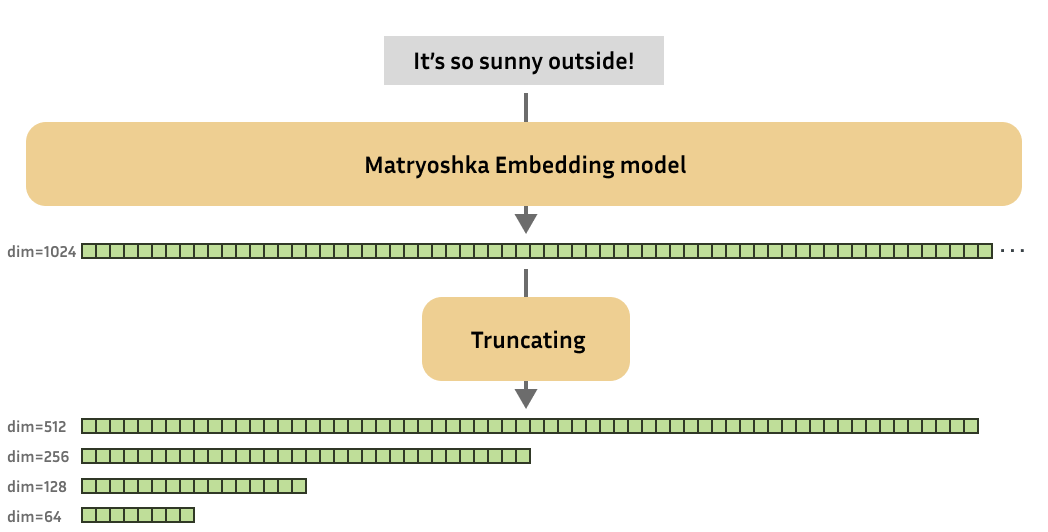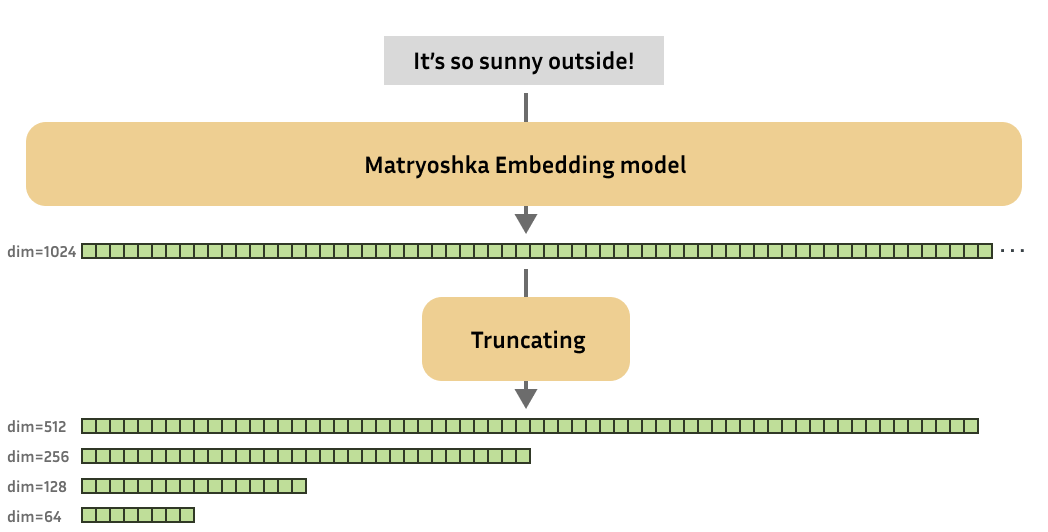

* Matryoshka Representation Learning (MRL) is a technique for training models to encode information at different granularities within the same embedding vector.
* This teaches the embedding model to encode coarser/higher-level information into earlier dimensions and finer details in later dimensions.
   * Named after Russian nesting dolls, this approach allows for flexible truncation of the embedding to different sizes while maintaining comparable accuracy to independently trained models of those smaller sizes, enabling adaptive compute-vs-accuracy trade-offs during deployment.

<img src="https://weaviate.io/assets/images/hero-237ed4b707a303e4ad3353daaf4edab8.jpeg" width=400>

* The main benefits of this technique are efficiency gains in vector storage and retrieval operations, as lower dimensional vectors (e.g., 64 vs 768 dimensions) require less memory and enable faster distance computations.
* The coarse-to-fine nature of Matryoshka representations enables particularly efficient multi-stage retrieval pipelines - for example, using low-dimensional representations (e.g., 16d) for fast initial candidate shortlisting, followed by re-ranking those candidates with higher-dimensional representations (e.g., 2048d) for better accuracy.
* This can achieve comparable accuracy to full-dimensional search while being up to 128x more computationally efficient.



## Why would you use 🪆 Matryoshka Embedding models?
* Such variable-size embedding models can be quite valuable to practitioners, for example [source](https://github.com/huggingface/blog/blob/main/matryoshka.md)

1. Shortlisting and reranking
   * Rather than performing your downstream task (e.g., nearest neighbor search) on the full embeddings, you can shrink the embeddings to a smaller size and very efficiently "shortlist" your embeddings.
   * Afterwards, you can process the remaining embeddings using their full dimensionality.

2. Trade-offs
    * Matryoshka models will allow you to scale your embedding solutions to your desired storage cost, processing speed, and performance.
     * From the original paper we can see using this compression like method the model performs just as well if not better than other representations:

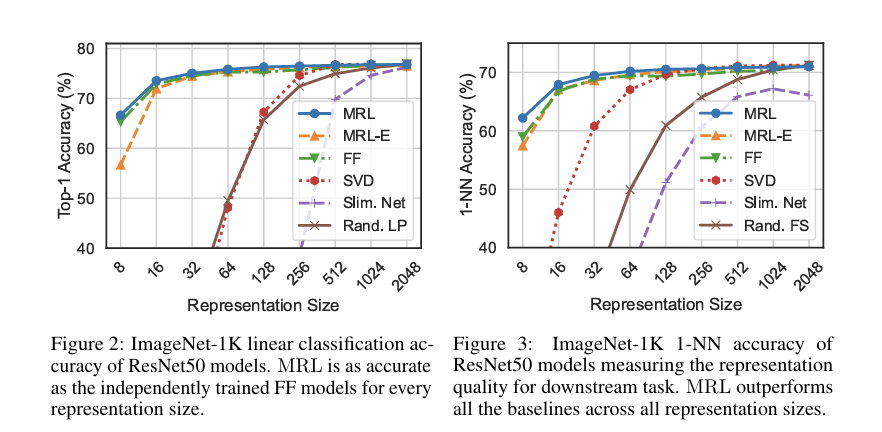

In [15]:
# 1. Create Candidate Dimensions of interest
matryoshka_dimensions = [768, 512, 256, 128, 64] ## dims: large --> small

# 2. Create empty list to hold evaluators
matryoshka_evaluators = []

# 3. Create an evaluator for each above dimension
for dim in matryoshka_dimensions:
    # Define the evaluator
    ir_evaluator = InformationRetrievalEvaluator(
        queries=queries,
        corpus=corpus,
        relevant_docs=relevant_docs,
        name=f"dim_{dim}",
        truncate_dim=dim,  # Truncate the embeddings to the respective dimension
        score_functions={"cosine": cos_sim},
    )
    # Add to list
    matryoshka_evaluators.append(ir_evaluator)

# 4. Create a sequential evaluator
### Able to run all our dimension specific InformationRetrievalEvaluators sequentially.
evaluator = SequentialEvaluator(matryoshka_evaluators)

### Adding Hit Rate Metric
* If you want to use the hit rate metric then uncomment the code below.
* To use hit rate we need to modify the `InformationRetrievalEvaluator` to include `hit rate` calculations. 
* We'll need to subclass it, the original code from `SentenceTransformers` is here: https://github.com/UKPLab/sentence-transformers/blob/master/sentence_transformers/evaluation/InformationRetrievalEvaluator.py

In [11]:
# from sentence_transformers.evaluation import InformationRetrievalEvaluator

# ## create custom class to add hit rate to the built-in InformationRetrievalEvaluator from huggingface
# class CustomIREvaluator(InformationRetrievalEvaluator):
#     def __init__(self, *args, **kwargs):
#         super().__init__(*args, **kwargs)

#     def compute_metrices(self, queries_result_list):
#         metrics = super().compute_metrices(queries_result_list)
        
#         # Calculate hit rates
#         for k in [1, 3, 5, 10]:
#             hits = sum(1 for query_id in self.queries for relevant_doc in self.relevant_docs[query_id] if relevant_doc in queries_result_list[query_id][:k])
#             hit_rate = hits / len(self.queries)
#             metrics[f'hit_rate@{k}'] = hit_rate

#         return metrics


# # 1. Create Candidate Dimensions of interest
# matryoshka_dimensions = [768, 512, 256, 128, 64] ## dims: large --> small

# # 2. Create empty list to hold evaluators
# matryoshka_evaluators = []

# ## 3. Create an evaluator for each above dimension
# for dim in matryoshka_dimensions:
#     # Define the evaluator
#     ir_evaluator = CustomIREvaluator(
#         queries=queries,
#         corpus=corpus,
#         relevant_docs=relevant_docs,
#         name=f"dim_{dim}",
#         truncate_dim=dim,  # Truncate the embeddings to the respective dimension
#         score_functions={"cosine": cos_sim},
#     )
#     # Add to list
#     matryoshka_evaluators.append(ir_evaluator)

# # 4. Create a sequential evaluator
# evaluator = SequentialEvaluator(matryoshka_evaluators)

# Information Retrieval Metrics
* These are baseline and very commonly used metrics for information retrieval which we will use to test the accuracy of the fine tuned model.

* Information retrieval systems require rigorous evaluation across multiple dimensions of performance.
* For embedding model evaluation, we will focus on 5 complementary metrics that together provide a comprehensive view of retrieval quality.
* **All metrics are `@k` which are at how many documents are retrieved.**

---
## 1. **Accuracy@k**

* The most fundamental metric, measuring the presence of at least one relevant document in the top-k results for each query.
* While simple, it provides essential validation of basic retrieval capability.
* An `Accuracy@k of 0.90` indicates that 90% of queries successfully retrieved at least one relevant document within their top k results.

Technical implementation:
```
Accuracy@k = (queries with ≥1 relevant doc in top k) / (total queries)
```

---
## 2. **NDCG@k (Normalized Discounted Cumulative Gain)**
* **This is the most important metric!!**
* **NDCG captures both the presence and positioning of relevant documents in ranked results.**
* **This is the MOST IMPORTANT AND KEY insight as it shows us whether relevant documents are appearing lower in the ranking contribute diminishing value to the overall score.**
* The normalization against an ideal ranking produces a score between 0 and 1, enabling comparison across different queries and result sets.

Technical implementation:
```
DCG@k = Σ(i=1 to k) rel_i / log2(i + 2)
NDCG@k = DCG@k / IDCG@k
```

Where rel_i represents the relevance (0 or 1) of the document at position i, and IDCG represents the DCG of a perfect ranking.

---
## 3. **Precision@k and Recall@k**

* These complementary metrics evaluate retrieval effectiveness from different perspectives:

* `Precision@k` measures result set accuracy by calculating the fraction of relevant documents among the top k results.
    * A `Precision@5 of 0.8` indicates that 4 of the top 5 results were relevant.

* `Recall@k` quantifies retrieval completeness by measuring the fraction of all relevant documents found within the top k results.
    * A `Recall@10 of 0.7` indicates that 70% of all relevant documents appear in the top 10 results.

Technical implementation:
```
Precision@k = (relevant docs in top k) / k
Recall@k = (relevant docs in top k) / (total relevant docs)
```

---
## 4. **Mean Reciprocal Rank (MRR@k)**

* MRR focuses specifically on the position of the **first relevant document in the ranking.**
* The reciprocal rank for a query is `1/position` of the first relevant result, with the final metric averaged across all queries.
* This is particularly valuable for evaluating systems where the position of the first relevant result is critical.

Technical implementation:
```
MRR = (1/|Q|) Σ(i=1 to |Q|) 1/rank_i
```

---
## 5. **Mean Average Precision (MAP@k)**

* MAP provides a comprehensive single-score assessment of ranking quality.
* It incorporates both the precision at each relevant document position and the total recall, making it particularly effective for evaluating overall retrieval performance.

Technical implementation:
```
AP@k = (1/min(k, R)) Σ(r=1 to k) (P@r * rel(r))
MAP@k = (1/|Q|) Σ(q=1 to |Q|) AP@k(q)
```

Where:
- R represents total relevant documents
- P@r is precision at rank r
- rel(r) is 1 for relevant results, 0 otherwise
- |Q| represents the total number of queries

---
## 6. Hit rate 
* This is a metric used in information retrieval to measure the effectiveness of a cache or retrieval system.
* It represents the proportion of successful retrievals from a cache or system compared to the total number of retrieval attempts.
* The equation for hit rate is:
```
Hit Rate = (Number of Successful Retrievals) / (Total Number of Retrieval Attempts)
```

Key points about hit rate:

1. It's expressed as a ratio or percentage.
2. A higher hit rate indicates better performance of the cache or retrieval system.
3. It's commonly used in caching systems, search engines, and database queries.
4. The complement of hit rate is miss rate (Miss Rate = 1 - Hit Rate).
5. Hit rate can be used to optimize cache size and replacement policies.

In information retrieval contexts, a "hit" typically means finding a relevant document or piece of information in response to a query. The hit rate thus indicates how often the system successfully returns relevant results.

---
Summary

* These metrics are evaluated at multiple k values (typically k=1,3,5,10 for most metrics, k=100 for MAP) to assess performance across different result depths.
* Together, they provide a comprehensive framework for evaluating retrieval systems across multiple dimensions:
  1. Basic retrieval capability (Accuracy)
  2. Ranking quality (NDCG)
  3. Result set precision and completeness (Precision/Recall)
  4. First-relevant-result positioning (MRR)
  5. Overall ranking effectiveness (MAP)
  6. Hit Rate (HR)

If you want to use hit rate metric, uncomment the code below

In [ ]:
# # Evaluate the model
# base_results = evaluator(model)

# # Print header
# print("\nBase Model Evaluation Results")
# print("-" * 85)
# print(f"{'Metric':15} {'768d':>12} {'512d':>12} {'256d':>12} {'128d':>12} {'64d':>12}")
# print("-" * 85)

# # List of metrics to display
# metrics = [
#     'ndcg@10',
#     'mrr@10',
#     'map@100',
#     'accuracy@1',
#     'accuracy@3',
#     'accuracy@5',
#     'accuracy@10',
#     'precision@1',
#     'precision@3',
#     'precision@5',
#     'precision@10',
#     'recall@1',
#     'recall@3',
#     'recall@5',
#     'recall@10',
#     'hit_rate@1',
#     'hit_rate@3',
#     'hit_rate@5',
#     'hit_rate@10'
# ]

# # Print each metric
# for metric in metrics:
#     values = []
#     for dim in matryoshka_dimensions:
#         key = f"dim_{dim}_cosine_{metric}"
#         values.append(base_results.get(key, float('nan')))  # Use NaN if metric is missing

#     # Highlight NDCG@10
#     metric_name = f"=={metric}==" if metric == "ndcg@10" else metric
#     print(f"{metric_name:15}", end="  ")
#     for val in values:
#         print(f"{val:12.4f}", end=" ")
#     print()

# # Print sequential score
# print("-" * 85)
# print(f"{'seq_score:'} {base_results['sequential_score']:1f}")

In [16]:
# Evaluate the model
base_results = evaluator(model)

# Print header
print("\nBase Model Evaluation Results")
print("-" * 85)
print(f"{'Metric':15} {'768d':>12} {'512d':>12} {'256d':>12} {'128d':>12} {'64d':>12}")
print("-" * 85)

# List of metrics to display
metrics = [
    'ndcg@10',
    'mrr@10',
    'map@100',
    'accuracy@1',
    'accuracy@3',
    'accuracy@5',
    'accuracy@10',
    'precision@1',
    'precision@3',
    'precision@5',
    'precision@10',
    'recall@1',
    'recall@3',
    'recall@5',
    'recall@10',
]

# Print each metric
for metric in metrics:
    values = []
    for dim in matryoshka_dimensions:
        key = f"dim_{dim}_cosine_{metric}"
        values.append(base_results[key])

    # Highlight NDCG@10
    metric_name = f"=={metric}==" if metric == "ndcg@10" else metric
    print(f"{metric_name:15}", end="  ")
    for val in values:
        print(f"{val:12.4f}", end=" ")
    print()

# Print sequential score
print("-" * 85)
print(f"{'seq_score:'} {base_results['sequential_score']:1f}")


Base Model Evaluation Results
-------------------------------------------------------------------------------------
Metric                  768d         512d         256d         128d          64d
-------------------------------------------------------------------------------------
==ndcg@10==            0.4417       0.4349       0.4188       0.3678       0.2776 
mrr@10                 0.3937       0.3926       0.3756       0.3201       0.2403 
map@100                0.4344       0.4318       0.4157       0.3618       0.2753 
accuracy@1             0.3524       0.3555       0.3400       0.2813       0.2087 
accuracy@3             0.3988       0.4003       0.3756       0.3091       0.2411 
accuracy@5             0.4606       0.4544       0.4482       0.3926       0.2906 
accuracy@10            0.5379       0.5162       0.4977       0.4637       0.3601 
precision@1            0.3524       0.3555       0.3400       0.2813       0.2087 
precision@3            0.3457       0.3493       0.3

For our matryoshka embedding evaluation, we track these metrics across multiple embedding dimensions: 768, 512, 256, 128, and 64. This helps us understand how retrieval quality changes as we reduce the embedding size.

This gives us a baseline to start with. 

Summary so far:
1. The `seq_score` gives the `ndcg@10` for 64 base dimension above.
2. The first metric listed is `ndcg@10` which is the most important metric we want to track. We can see for the highest dimension of 768 how it currently performs at 0.4417, obviously our goal is to beat this with fine tuning.

---
# Fine-Tuning (Training)
* Nowe we can fine-tune the model on the dataset.

* Now with our training data prepared, our evaluation methodology ready, and our base model loaded with baseline metrics- it's time to train!

* We'll continue using Sentence Transformers [fine-tuning](https://sbert.net/docs/sentence_transformer/training_overview.html) tools, see linked documentation for further details.

* Starting, let's load our base model with a few additional arguments, namely using Scaled Dot Product Attention (SDPA) for GPU efficiencies, and a base model card for uploading to Hugging Face.

## 1. Setup Model
* First we setup the model with a few optimizations:
  * scaled dot product attention (sdpa)
* We also create a hugging face model card to upload the model to hugging face.

In [18]:
# load model with SDPA for using Flash Attention 2
model = SentenceTransformer(
    model_id,
    model_kwargs={"attn_implementation": "sdpa"}, ## scaled dot product attention for GPU efficiency
    ## hugging face model card
    model_card_data=SentenceTransformerModelCardData(
        language="en",
        license="apache-2.0",
        model_name="ModernBERT Embed base Legal Matryoshka",
    ),
)

## 2. Loss functions

* Next we need to define a loss function.
* Loss functions are used to guide the model towards improvements at train time, generally comparing current performance with expected performance, calculating the difference, and then the value determines the direction we optimize towards.
* Basically this tells us "how wrong we are vs. how right we are."
* Loss functions or cost functions are the hallmark of machine learning and deep learning. 

Sentence Transformers offers [many different loss functions](https://sbert.net/docs/sentence_transformer/loss_overview.html) for various scenarios. Given our commitment to MRL training, we will need not only a base loss function, but an additional adapter.
### Loss Function #1 -- `MultipleNegativesRankingLoss`
* Given our data structure of positive pairs, we utilize [`MultipleNegativesRankingLoss`](https://sbert.net/docs/package_reference/sentence_transformer/losses.html#multiplenegativesrankingloss) which optimizes for retrieval scenarios by treating each batch as (a₁, p₁)...(aₙ, pₙ) pairs where (aᵢ, pᵢ) are positive pairs and (aᵢ, pⱼ) for i≠j become negative pairs.
* This effectively samples n-1 negative examples per positive pair within each batch, with performance scaling with batch size.

### Loss function #2 - `MatryoshkaLoss`
* We wrap this with [`MatryoshkaLoss`](https://sbert.net/docs/package_reference/sentence_transformer/losses.html#matryoshkaloss) to enable multi-dimensional embedding training, allowing for dynamic dimensionality reduction at inference time without requiring retraining.

In [19]:
# Initial Loss
base_loss = MultipleNegativesRankingLoss(model)

# Matryoshka Loss Wrapper
train_loss = MatryoshkaLoss(
    model, base_loss, matryoshka_dims=matryoshka_dimensions
)

## 3. Training Hyperparameters

* Below are the defined training hyperparameters.
* These are taken directly from the aforementioned [Philipp Schmid's original blogpost](https://www.philschmid.de/fine-tune-embedding-model-for-rag#4-fine-tune-embedding-model-with-sentencetransformerstrainer).
* It is worth testing various combinations of hyperparameters for optimal performance, but for the sake of this demonstration we will default to Philipp's provided arguments.

In [20]:
# Training Arguments
args = SentenceTransformerTrainingArguments(
    output_dir="modernbert-embed-base-legal-matryoshka-adamNLP", # output directory and HF model ID
    num_train_epochs=4,                                        # number of epochs
    per_device_train_batch_size=32,                            # train batch size
    gradient_accumulation_steps=16,                            # for a global batch size of 512
    per_device_eval_batch_size=16,                             # evaluation batch size
    warmup_ratio=0.1,                                          # warmup ratio
    learning_rate=2e-5,                                        # learning rate, 2e-5 is a good value
    lr_scheduler_type="cosine",                                # use cosine learning rate scheduler
    optim="adamw_torch_fused",                                 # use fused adamw optimizer
    tf32=True,                                                 # use tf32 precision
    bf16=True,                                                 # use bf16 precision
    batch_sampler=BatchSamplers.NO_DUPLICATES,                 # MultipleNegativesRankingLoss benefits from no duplicate samples in a batch
    eval_strategy="epoch",                                     # evaluate after each epoch
    save_strategy="epoch",                                     # save after each epoch
    logging_steps=10,                                          # log every 10 steps
    save_total_limit=3,                                        # save only the last 3 models
    load_best_model_at_end=True,                               # load the best model when training ends
    metric_for_best_model="eval_dim_128_cosine_ndcg@10",       # Optimizing for the best ndcg@10 score for the 128 dimension
    report_to="none"                                           # Turning off training logging for now, input 'wandb' etc. if desired.
)

Finally, package our model, training arguments, dataset, loss function and evaluator together into a `SentenceTransformerTrainer`

## 4. Setup Hugging Face Trainer

In [21]:
## HF trainer
trainer = SentenceTransformerTrainer(
    model=model,
    args=args,
    train_dataset=train_dataset.select_columns(
        ["positive", "anchor"]
    ),  # training dataset
    loss=train_loss,
    evaluator=evaluator,
)

Computing widget examples:   0%|          | 0/1 [00:00<?, ?example/s]

## 5. Start the training run!

In [22]:
# Start training
trainer.train()

# Save the best model based on our eval_dim_128_cosine_ndcg@10 criteria
trainer.save_model()

Column 'anchor' is at index 1, whereas a column with this name is usually expected at index 0. Note that the column order can be important for some losses, e.g. MultipleNegativesRankingLoss will always consider the first column as the anchor and the second as the positive, regardless of the dataset column names. Consider renaming the columns to match the expected order, e.g.:
dataset = dataset.select_columns(['anchor', 'positive', 'negative'])


Epoch,Training Loss,Validation Loss,Dim 768 Cosine Accuracy@1,Dim 768 Cosine Accuracy@3,Dim 768 Cosine Accuracy@5,Dim 768 Cosine Accuracy@10,Dim 768 Cosine Precision@1,Dim 768 Cosine Precision@3,Dim 768 Cosine Precision@5,Dim 768 Cosine Precision@10,Dim 768 Cosine Recall@1,Dim 768 Cosine Recall@3,Dim 768 Cosine Recall@5,Dim 768 Cosine Recall@10,Dim 768 Cosine Ndcg@10,Dim 768 Cosine Mrr@10,Dim 768 Cosine Map@100,Dim 512 Cosine Accuracy@1,Dim 512 Cosine Accuracy@3,Dim 512 Cosine Accuracy@5,Dim 512 Cosine Accuracy@10,Dim 512 Cosine Precision@1,Dim 512 Cosine Precision@3,Dim 512 Cosine Precision@5,Dim 512 Cosine Precision@10,Dim 512 Cosine Recall@1,Dim 512 Cosine Recall@3,Dim 512 Cosine Recall@5,Dim 512 Cosine Recall@10,Dim 512 Cosine Ndcg@10,Dim 512 Cosine Mrr@10,Dim 512 Cosine Map@100,Dim 256 Cosine Accuracy@1,Dim 256 Cosine Accuracy@3,Dim 256 Cosine Accuracy@5,Dim 256 Cosine Accuracy@10,Dim 256 Cosine Precision@1,Dim 256 Cosine Precision@3,Dim 256 Cosine Precision@5,Dim 256 Cosine Precision@10,Dim 256 Cosine Recall@1,Dim 256 Cosine Recall@3,Dim 256 Cosine Recall@5,Dim 256 Cosine Recall@10,Dim 256 Cosine Ndcg@10,Dim 256 Cosine Mrr@10,Dim 256 Cosine Map@100,Dim 128 Cosine Accuracy@1,Dim 128 Cosine Accuracy@3,Dim 128 Cosine Accuracy@5,Dim 128 Cosine Accuracy@10,Dim 128 Cosine Precision@1,Dim 128 Cosine Precision@3,Dim 128 Cosine Precision@5,Dim 128 Cosine Precision@10,Dim 128 Cosine Recall@1,Dim 128 Cosine Recall@3,Dim 128 Cosine Recall@5,Dim 128 Cosine Recall@10,Dim 128 Cosine Ndcg@10,Dim 128 Cosine Mrr@10,Dim 128 Cosine Map@100,Dim 64 Cosine Accuracy@1,Dim 64 Cosine Accuracy@3,Dim 64 Cosine Accuracy@5,Dim 64 Cosine Accuracy@10,Dim 64 Cosine Precision@1,Dim 64 Cosine Precision@3,Dim 64 Cosine Precision@5,Dim 64 Cosine Precision@10,Dim 64 Cosine Recall@1,Dim 64 Cosine Recall@3,Dim 64 Cosine Recall@5,Dim 64 Cosine Recall@10,Dim 64 Cosine Ndcg@10,Dim 64 Cosine Mrr@10,Dim 64 Cosine Map@100,Sequential Score
1,90.661200,No log,0.533230,0.578053,0.639876,0.720247,0.533230,0.505925,0.383617,0.223648,0.187146,0.492530,0.606904,0.705951,0.623843,0.574027,0.613596,0.514683,0.554869,0.613601,0.693972,0.514683,0.488408,0.366924,0.214529,0.180706,0.477202,0.581530,0.676971,0.599596,0.553315,0.595058,0.485317,0.520866,0.588872,0.673879,0.485317,0.461103,0.350541,0.208655,0.166795,0.448223,0.554225,0.655848,0.572989,0.524349,0.564078,0.425039,0.459042,0.527048,0.613601,0.425039,0.404946,0.310355,0.191190,0.146960,0.394384,0.491757,0.599433,0.515559,0.464693,0.505638,0.319938,0.341577,0.408037,0.480680,0.319938,0.300876,0.237094,0.147759,0.110896,0.293019,0.376095,0.464838,0.393934,0.352209,0.389295,0.393934
2,40.400600,No log,0.570325,0.612056,0.692427,0.752705,0.570325,0.535806,0.407110,0.235085,0.203117,0.526533,0.646832,0.743174,0.662299,0.611374,0.649876,0.537867,0.588872,0.669243,0.741886,0.537867,0.512622,0.394436,0.230294,0.188691,0.500902,0.625322,0.728748,0.639109,0.584321,0.625173,0.517774,0.550232,0.627512,0.712519,0.517774,0.488923,0.370634,0.221947,0.180319,0.476687,0.583591,0.697321,0.610225,0.558030,0.598634,0.446677,0.497682,0.571870,0.653787,0.446677,0.431736,0.335394,0.205719,0.155075,0.418856,0.530783,0.641422,0.550453,0.493361,0.535794,0.341577,0.377125,0.438949,0.510046,0.341577,0.328181,0.258733,0.157960,0.117465,0.316589,0.406491,0.495750,0.421848,0.377732,0.417750,0.421848
3,26.954700,No log,0.570325,0.615147,0.692427,0.757342,0.570325,0.538382,0.408037,0.236785,0.202859,0.529238,0.648892,0.748197,0.665342,0.613067,0.652441,0.542504,0.591963,0.667697,0.741886,0.542504,0.516744,0.394745,0.230294,0.190237,0.504379,0.624807,0.728490,0.640895,0.587536,0.629009,0.520866,0.561051,0.638331,0.714065,0.520866,0.495106,0.379598,0.223648,0.180191,0.479778,0.597630,0.702344,0.615579,0.562987,0.604062,0.468315,0.516229,0.584235,0.663060,0.468315,0.450283,0.346213,0.208037,0.162416,0.436631,0.545337,0.652112,0.565683,0.512199,0.552796,0.360124,0.394127,0.462133,0.527048,0.360124,0.346213,0.272334,0.163988,0.123648,0.333076,0.428259,0.5

Optionally save the model to Hugging Face

You can find my chosen run uploaded with more information here: https://huggingface.co/adamNLP/modernbert-embed-base-legal-matryoshka-2

In [23]:
# Upload model to hub
trainer.model.push_to_hub("modernbert-embed-base-legal-matryoshka-2")

model.safetensors:   0%|          | 0.00/596M [00:00<?, ?B/s]

'https://huggingface.co/adamNLP/modernbert-embed-base-legal-matryoshka-2/commit/a60a9f507830ff948ce6e7e69d7974855006f75e'

---
# Evaluate Trained Model
* Now we need to compare the same retrieval metrics that we had a baseline on above to the fine-tuned model on the domain specific data.

In [24]:
## load fine tuned model from HF hubh
fine_tuned_model = SentenceTransformer(
    args.output_dir, device="cuda" if torch.cuda.is_available() else "cpu"
)

# Evaluate the model
ft_results = evaluator(fine_tuned_model)

# Print header
print("Fine Tuned Model Evaluation Results")
print("-" * 85)
print(f"{'Metric':15} {'768d':>12} {'512d':>12} {'256d':>12} {'128d':>12} {'64d':>12}")
print("-" * 85)

# List of metrics to display
metrics = [
    'ndcg@10',
    'mrr@10',
    'map@100',
    'accuracy@1',
    'accuracy@3',
    'accuracy@5',
    'accuracy@10',
    'precision@1',
    'precision@3',
    'precision@5',
    'precision@10',
    'recall@1',
    'recall@3',
    'recall@5',
    'recall@10'
]

# Print each metric
for metric in metrics:
    values = []
    for dim in matryoshka_dimensions:
        key = f"dim_{dim}_cosine_{metric}"
        values.append(ft_results[key])

    # Highlight NDCG@10
    metric_name = f"=={metric}==" if metric == "ndcg@10" else metric
    print(f"{metric_name:15}", end="  ")
    for val in values:
        print(f"{val:12.4f}", end=" ")
    print()

# Print sequential score
print("-" * 85)
print(f"{'seq_score:'} {ft_results['sequential_score']:1f}")

Fine Tuned Model Evaluation Results
-------------------------------------------------------------------------------------
Metric                  768d         512d         256d         128d          64d
-------------------------------------------------------------------------------------
==ndcg@10==            0.6639       0.6429       0.6170       0.5619       0.4388 
mrr@10                 0.6116       0.5897       0.5655       0.5083       0.3962 
map@100                0.6512       0.6305       0.6062       0.5495       0.4361 
accuracy@1             0.5688       0.5456       0.5240       0.4637       0.3601 
accuracy@3             0.6151       0.5904       0.5641       0.5116       0.3910 
accuracy@5             0.6924       0.6677       0.6430       0.5842       0.4621 
accuracy@10            0.7558       0.7450       0.7110       0.6615       0.5224 
precision@1            0.5688       0.5456       0.5240       0.4637       0.3601 
precision@3            0.5374       0.5178     

Summary
* We can see the significant improvement especially for the `ndcg@10` for 768 dimensions where we went from 44.17% now to 66.39% which is significant.

---
## Base vs FT Comparison

| Metric | Dimension | Base | Fine-tuned | Abs. Improvement | % Improvement |
|---------|-----------|------|------------|-----------------|---------------|
| ndcg@10 | 768d | 0.4435 | 0.6584 | 0.2149 | 48.5% |
| ndcg@10 | 512d | 0.4308 | 0.6536 | 0.2228 | 51.7% |
| ndcg@10 | 256d | 0.4014 | 0.6244 | 0.2230 | 55.6% |
| ndcg@10 | 128d | 0.3571 | 0.5504 | 0.1933 | 54.1% |
| ndcg@10 | 64d | 0.2682 | 0.4275 | 0.1593 | 59.4% |
| mrr@10 | 768d | 0.3927 | 0.5998 | 0.2071 | 52.7% |
| mrr@10 | 512d | 0.3748 | 0.5939 | 0.2191 | 58.5% |
| mrr@10 | 256d | 0.3478 | 0.5682 | 0.2204 | 63.4% |
| mrr@10 | 128d | 0.3128 | 0.4878 | 0.1750 | 55.9% |
| mrr@10 | 64d | 0.2276 | 0.3813 | 0.1537 | 67.5% |
| map@100 | 768d | 0.4365 | 0.6401 | 0.2036 | 46.6% |
| map@100 | 512d | 0.4204 | 0.6345 | 0.2141 | 50.9% |
| map@100 | 256d | 0.3936 | 0.6093 | 0.2157 | 54.8% |
| map@100 | 128d | 0.3540 | 0.5334 | 0.1794 | 50.7% |
| map@100 | 64d | 0.2640 | 0.4235 | 0.1595 | 60.4% |

Some impressive results given our fine tuning! Generalizing effectively to unseen queries across the existing knowledgebase.

Further testing would have to be ran to understand how well this model may generalize to unseen documents outside of the knowledgebase.

---
## Using the Model

The resulting model has been published here: [AdamLucek/ModernBERT-embed-base-legal-MRL](https://huggingface.co/AdamLucek/ModernBERT-embed-base-legal-MRL)  
Along with the dataset: [AdamLucek/legal-rag-positives-synthetic](https://huggingface.co/datasets/AdamLucek/legal-rag-positives-synthetic)

The model can now be loaded and used like any other sentence transformers model:

In [25]:
%%capture
!pip install --upgrade sentence-transformers
!pip install git+https://github.com/huggingface/transformers

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [26]:
from sentence_transformers import SentenceTransformer

# Download from the 🤗 Hub
model = SentenceTransformer("adamNLP/modernbert-embed-base-legal-matryoshka-2", truncate_dim=256)

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/205 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/31.9k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/54.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/596M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/20.8k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/3.58M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/694 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/296 [00:00<?, ?B/s]

In [27]:
# Run inference on the fine tuned model
sentences = [
    'Which organization is Carmody Gaba Daman associated with?',
    'Assistant General Counsel, U.S. General Services Administration, Washington, D.C.; Carmody Gaba Daman, Assistant General Counsel, U.S. General Services Administration, Washington, D.C.; Michael Blumenthal, Trial Attorney, U.S. Small Business Administration, Office of General Counsel, Washington, D.C. MEMORANDUM AND ORDER', # Corresponding Positive
    'certain Solicitation requirements violate federal procurement statutes and agency regulations governing procurements involving small business offerors. See generally SHS MJAR at 14; VCH MJAR at 14. Having considered the parties’ arguments, applicable law, and the Administrative Record, this Court GRANTS in part and DENIES in part Plaintiffs’ Motions for Judgment on the', # Random Excerpt
]

embeddings = model.encode(sentences)
print(embeddings.shape)

(3, 256)


In [28]:
# Get the similarity scores for the embeddings
similarities = model.similarity(embeddings, embeddings)
print(similarities[0])

tensor([ 1.0000,  0.5893, -0.0059])


For comparison, output from our base model nomic-ai/modernbert-embed-base: `tensor([1.0000, 0.6490, 0.4759])`